In [18]:
%pip install imageio

     |████████████████████████████████| 3.3MB 3.4MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import os
import random
import tensorflow as tf
import imageio

In [2]:
dir(imageio)
#mageio.imread

['RETURN_BYTES',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 'core',
 'formats',
 'get_reader',
 'get_writer',
 'help',
 'imread',
 'imsave',
 'imwrite',
 'mimread',
 'mimsave',
 'mimwrite',
 'mvolread',
 'mvolsave',
 'mvolwrite',
 'plugins',
 'read',
 'save',
 'show_formats',
 'volread',
 'volsave',
 'volwrite']

In [4]:
def get_images(paths, labels, nb_samples=None, shuffle=True):
    """
    Takes a set of character folders and labels and returns paths to image files
    paired with labels.
    Args:
        paths: A list of character folders
        labels: List or numpy array of same length as paths
        nb_samples: Number of images to retrieve per character
    Returns:
        List of (label, image_path) tuples
    """
    if nb_samples is not None:
        sampler = lambda x: random.sample(x, nb_samples)
    else:
        sampler = lambda x: x
    images_labels = [(i, os.path.join(path, image))
                     for i, path in zip(labels, paths)
                     for image in sampler(os.listdir(path))]
    if shuffle:
        random.shuffle(images_labels)
    return images_labels

In [5]:
def image_file_to_array(filename, dim_input):
    """
    Takes an image path and returns numpy array
    Args:
        filename: Image filename
        dim_input: Flattened shape of image
    Returns:
        1 channel image
    """
    image = imageio.imread(filename)
    image = image.reshape([dim_input])
    image = image.astype(np.float32) / 255.0
    image = 1.0 - image
    return image

In [3]:
class DataGenerator(object):
    """
    Data Generator capable of generating batches of Omniglot data.
    A "class" is considered a class of omniglot digits.
    """

    def __init__(self, num_classes, num_samples_per_class, config={}):
        """
        Args:
            num_classes: Number of classes for classification (K-way)
            num_samples_per_class: num samples to generate per class in one batch
            batch_size: size of meta batch size (e.g. number of functions)
        """
        self.num_samples_per_class = num_samples_per_class
        self.num_classes = num_classes

        data_folder = config.get('data_folder', './omniglot_resized')
        self.img_size = config.get('img_size', (28, 28))

        self.dim_input = np.prod(self.img_size)
        self.dim_output = self.num_classes

        character_folders = [os.path.join(data_folder, family, character)
                             for family in os.listdir(data_folder)
                             if os.path.isdir(os.path.join(data_folder, family))
                             for character in os.listdir(os.path.join(data_folder, family))
                             if os.path.isdir(os.path.join(data_folder, family, character))]

        random.seed(1)
        random.shuffle(character_folders)
        num_val = 100
        num_train = 1100
        self.metatrain_character_folders = character_folders[: num_train]
        self.metaval_character_folders = character_folders[
            num_train:num_train + num_val]
        self.metatest_character_folders = character_folders[
            num_train + num_val:]

    def sample_batch(self, batch_type, batch_size):
        """
        Samples a batch for training, validation, or testing
        Args:
            batch_type: train/val/test
        Returns:
            A a tuple of (1) Image batch and (2) Label batch where
            image batch has shape [B, K, N, 784] and label batch has shape [B, K, N, N]
            where B is batch size, K is number of samples per class, N is number of classes
        """
        if batch_type == "train":
            folders = self.metatrain_character_folders
        elif batch_type == "val":
            folders = self.metaval_character_folders
        else:
            folders = self.metatest_character_folders

        #############################
        #### YOUR CODE GOES HERE ####
        pass
        #############################

        return all_image_batches, all_label_batches

In [65]:
data_folder = './omniglot_resized'

character_folders = [os.path.join(data_folder, family, character)
                             for family in os.listdir(data_folder)
                             if os.path.isdir(os.path.join(data_folder, family))
                             for character in os.listdir(os.path.join(data_folder, family))
                             if os.path.isdir(os.path.join(data_folder, family, character))]

#print(character_folders)
os.listdir(character_folders[0])
num_samples_per_class=2 #one shot learning, replace with self.num_samples_per_class, K
num_classes=5 #number of classes to be used in classification, replace with self.num_classes, N
batch_type="train"
batch_size=16

labels_images=[]

for i in range(batch_size):
    paths=random.sample(character_folders, num_classes)
    labels=np.eye(num_classes).tolist()
    for j in range(num_samples_per_class):
        labels_images.extend(get_images(paths, labels, 1, shuffle=True))
    
all_image_batches=[image_file_to_array(label_image[1],784) for label_image in labels_images] 
all_label_batches=[label_image[0] for label_image in labels_images]
all_image_batches=np.reshape(all_image_batches,(batch_size, num_samples_per_class, num_classes, 784))
all_label_batches=np.reshape(all_label_batches, (batch_size, num_samples_per_class, num_classes, num_classes))

array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0

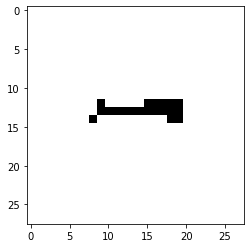

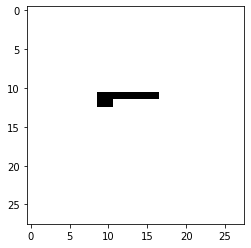

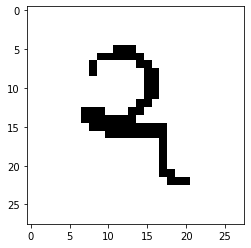

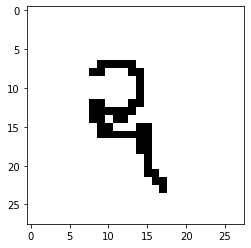

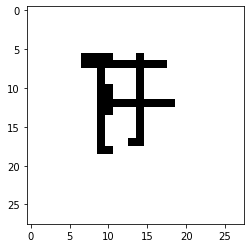

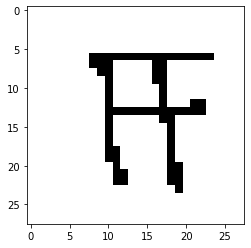

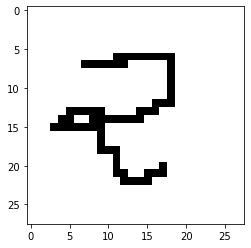

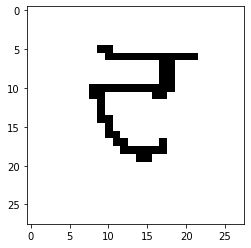

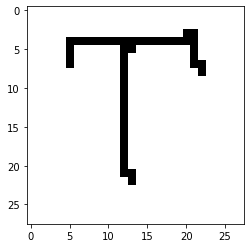

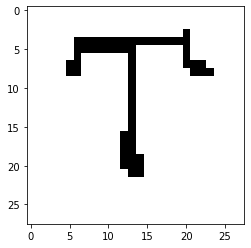

In [110]:
from PIL import Image
import matplotlib.pyplot as plt

paths=random.sample(character_folders, 10)
labels=np.eye(5).tolist()
labels_images=get_images(paths, labels, 2, shuffle=False)    
image_files =[label_image[1] for label_image in labels_images]

for image_file in image_files[:20]:
    img=Image.open(image_file)
    plt.figure()
    plt.imshow(img)

In [ ]:
def get_images(paths, labels, nb_samples=None, shuffle=True):
    """
    Takes a set of character folders and labels and returns paths to image files
    paired with labels.
    Args:
        paths: A list of character folders
        labels: List or numpy array of same length as paths
        nb_samples: Number of images to retrieve per character
    Returns:
        List of (label, image_path) tuples
    """
    
def image_file_to_array(filename, dim_input):
    """
    Takes an image path and returns numpy array
    Args:
        filename: Image filename
        dim_input: Flattened shape of image
    Returns:
        1 channel image
    """

In [10]:
#self.num_samples_per_class = num_samples_per_class
#self.num_classes = num_classes
num_samples_per_class=1 #one shot learning, replace with self.num_samples_per_class
num_classes=5 #number of classes to be used in classification, replace with self.num_classes
batch_type="train"
batch_size=16
# B=16, K=1, N=5

num_train = 1100
#len(character_folders)
folders = character_folders[: num_train]


def sample_batch(self, batch_type, batch_size):
    """
    Samples a batch for training, validation, or testing
    Args:
        batch_type: train/val/test
    Returns:
        A a tuple of (1) Image batch and (2) Label batch where
        image batch has shape [B, K, N, 784] and label batch has shape [B, K, N, N]
        where B is batch size, K is number of samples per class, N is number of classes
    """
    if batch_type == "train":
        folders = self.metatrain_character_folders
    elif batch_type == "val":
        folders = self.metaval_character_folders
    else:
        folders = self.metatest_character_folders

    #############################
    #### YOUR CODE GOES HERE ####
    pass
    #############################

    return all_image_batches, all_label_batches